### Python package for production code of model deployment

#### What is production code
* production code is designed to be deployed to end users
* production code considerations include testability and maintainability
  * divide code into modules which are more extensible and easier to test
  * separate config from code where possible
  * ensure functionality is tested and documented
  * code adheres to standards such as pep8 so that it is easy for others to read
* scalability and performance
  + code needs to be ready to be deployed to infrastructure that can be scaled
    + containerization for vertical or horizontal scaling
  + refactor inefficient parts of the code base
* reproducibility
  + conde should be under version control with clear processes for tracking releases and release versions
  + requierments, files, makr which dependencies and which versions are used by the code  

### Python packages
* The overall folder and file structures in the parent folder of the package
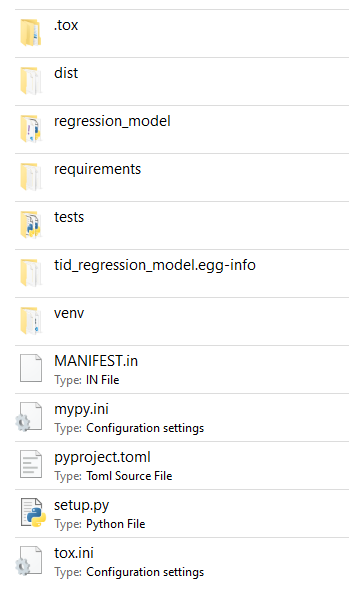

* a module is a file which contains python functions and global variables. It is just a file with a .py extension
* a package is a collection of modules
  + has certain standardized files which have to be present so that it can be published and installed in apps
  + it allows to wrap train model and make it available to other consuming applications as a dependency
  + additional benefits of version control, clear metadata and reproducibility
  + have to follow certain python standards and conventions
* how to package up machine learning module into python package
  + how to structure the package
    + MANIFEST.in, mypy.ini, pyproject.toml, tox.ini and setup.py are used for packaging and configuring
    + .tox is where tox install virtual environment
    + requirements folder contains dependencies for package and for testing it
      + contains requirements.txt and test_requirements.txt
    + tests folder contains pytest scripts for tests
    + regression_model directory contains key files for the model
      + The folder and file structure in `regression_model` folder is show below:
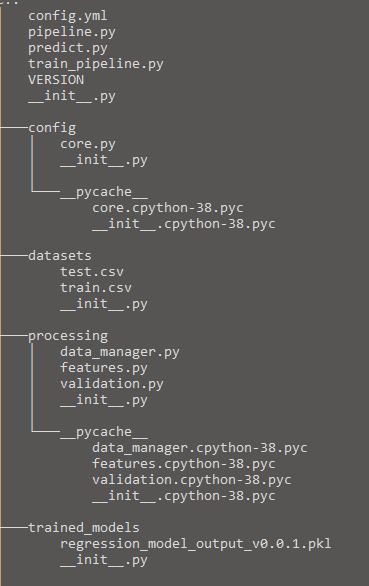
      + train_pipeline.py, predict.py and pipeline.py
      + trained_models
        + stores trained models as pickle file
      + other directories for help functions
        + config
        + datasets contains train.csv and test.csv
        + processing
          + data_manager.py for loading and training data
          + features
          + validations
          

#### requirements.txt
Basic way to manage packages
* the following is a requirments.txt file
* package were included with version requriments in major_version:minor_version:patches
  + major version include major changes that may break the API
  + minor version include minor changes that do not break API, but some may still break API
  + patches are bug fixes
* this requirements.txt does not allow minor version changes
* if we don't define the versione of packages
  + pip will install the lateset version that may break APIs
    + that version may have progressed
    + releaase new features
    + release new major version
  + our packages will become very brittle and broken
* install package by pip install -r requirements.txt
* if we don't have this file, other pepole will fail to install the package due to lack of necessary dependencies

#### test_requirement.txt
* -r means we need to install pakcages from requirements.txt first
* this test_requirements.txt is not required for all use cases. Only when you need to do test

### Working with tox
* we use tox to trigger pipeline script
* tox is a generic virturalenv management and test command line tool 
* we can run tox on different OS systems to get the same behavior across the platforms
* we don't need to worry about python paths, configuring environment variables
* we config all these in tox.ini file
* powerful for
  + run tests of different versions of python
  + set up environment variables
  + get over operating system differences
* install by "pip install tox"  

### Start to use tox
* everything is cnfigured in tox.ini file
* items with `[]` are tox environments
  + an environment is used to set up a virtual environment in .tox directory
  + enviornments are the foundation units we work with tox
  + we can run commands in a specific environment
  + we can inherit commands and dependencies from other environments
* we have a defalut tox environment and a default test environment
  + if we just run tox command on its own, it's going to run all the commands in different environments
    + it will run test_package, typechecks, stylechecks, lint
  + testenv is our base class, it has install_commands 
    + in testenv:test_package environment, we will install test_requirements.txt
      + we then set the evironment variable such as PYTHONPATH and PYTHONHASHSEED
      + we then run commands to train and use pytest -s -vv, and {posargs:tests,} as the directory to trigger tests
    + in testenv:train environment, we only run train_pipeline.py
* if we run tox -e test_package, then command in testenv:test_package will run
  + -e means we will define environment variables
* if we run tox without -e, then all environments in [tox] will run 

### Config file
* config file in regression_model folder
* why don't use python code for configuration?
  + you need to limit the power that your config files have
  + when you write config file in python, you may add some python code that can cause bugs
  + config files in standard format, such as yaml and json can be edited b developers who don't know python
  + convert all global variables in jupyter notebook and switch them to yaml file

### core.py file in config folde
* use pathlib to define locations of files and directories (newer way than os)
  + define project directories
* use pydantic to define classes representing the config
  + pydantic a library for data validation and setting management using python type annotations
  + we create class based on BaseModel, and define attributes of the class
    + when we load data/class objects, we can validate if the attributes have the correct types
    + we don't need special tools for schema validation, just use python typing hint
    + validation is applied to both AppConfig/package and ModelConfig for application and model config validations
    + we then wrap AppConfig and ModelConfig into a Config class
* we have three help functions to check and load config files for validation
* when you run tox, the config files will be used to validate the model and pacakge
* config files protect ourselves from incorrect config and build a lot of tests for correct config
  + powerful way to protect us from introducing bugs into our model

### Model Training script and pipeline
* regression_modle/train_pipeline.py
* the funciton is run_training
  + first load dataset by load_dataset function
  + data processing constants, including features, target, and test dataset size, and random_state are set by config
  + the pipeline is defined in pipeline.py
  + processing/data_manage.py
    + load_data function is in processing/data_manager.py. 
      + reads input csv data by a pandas dataframe
      + the directory and file names are defined in config file, which is read by core.py file in config folder
      + the column names are renamed, with "columns" argument of pd.rename defined by config file, too
    + save_pipeline function save the pipeline as pickle object. The file name was configed, too
      + the version part of the file name comes from the version of the package defined by __version__
      + the model was then saved by joblib.dump      
   + remove_old_pipelines do the clean up to keep only one model for each version    

### Features module
* use BaseEstimator and TransformerMixin parent class to implement fit and transform functions
* These classes are called by pipeline.py with constant arguments defined in config file
* the feature transformer are tested in test/test_features.py file using pytest framework
  + the input data file for test is configued in config file
  + the expected values in assert statements are hard-coded
* run the test using tox (tox -e test_package
  + feature engineering is a very common cause of bugs
  + very important to ensure any feature engineering code is tested
  + use the transformer in this file as a template to develop other transformers

### Preidctions: predict.py
* first obtain the pickle file name for the model pipeline
* load pipeline for prediction
* it contains a validate_inputs function
  + use pydantic to do valication
  + a list of HouseDataInputSchema is wrapped into a MultipleHouseDataInputs object
  + the input is a pandas data frame, after replacing np.nan to None and convert each row to a dictionary  

### Building the package
* pyproject.toml
   ```yaml   
  [build-system]
requires = [
    "setuptools>=42",
    "wheel"
]
build-backend = "setuptools.build_meta"
```
```
These are the tools used to build up the package
* setup.py file is the code used to build the package
* manifest file defines which files need to be included and excluded in the package

* procedure to build package
  + python -m build will generate the following directory and files
    + dist folder
      + two files in this folder
        + package_name-0.0.2.tar.gz  (legacy build)
        + package_name-0.0.1-py3-none-any.whl (faster to build)
    + build folder
    + package_name.egg-info folder